In [1]:
from MainFiles.GP import *
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.distributions as tdb
from Windowing import *

# Introduction
Here we check out what the multivariate gaussian distribution actually gives

Also we try to max the probability of the distribution at the specific values

# Method
We sample it for some parameters

In [2]:
def sing_cov(x,y,param):
    sigma = param[-1]
    if param[-1] == 0:
        sigma = 1e-3
    exponential1 = torch.sign(param[2]) * torch.pow(torch.abs(param[2]), param[1])
    sum = x+y+param[1]
    exponential2 = torch.sign(sum) * torch.pow(torch.abs(sum), param[0])
    return exponential1 / exponential2 + sigma**2 * (x == y)

In [76]:
ts = torch.tensor([16,   23,   32,   45,   64,   91,  128,  181,  256,  362,  512,
        724, 1024, 1448, 2048])
param = torch.tensor([0.1,0.3,0.01])

means = torch.full(ts.shape, 0.5)
cov = cov_kernel(ts,ts[...,None],param)

S = tdb.MultivariateNormal(means,cov).sample(sample_shape=torch.Size([1000])).mean(0)


AttributeError: 'float' object has no attribute 'dim'

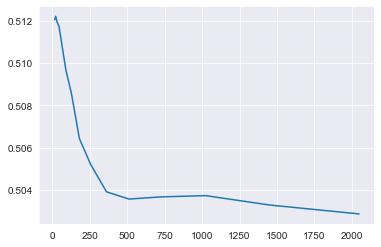

In [53]:
plt.plot(ts,S)

In [29]:
S.shape

torch.Size([1000, 15])

In [57]:
N = tdb.MultivariateNormal(means,cov)

In [68]:
N.log_prob(S)

AttributeError: 'MultivariateNormal' object has no attribute 'probs'

In [66]:
np.exp(39)

8.659340042399374e+16

# Method
Ok so density can be arbitrarily high since for continuous only cdf counts so lets give this a try
Now lets try to optimize the log_prob

In [3]:
win = Windowing(aggCurves)
win.set_points([16,   23,   32,   45,   64,   91,  128,  181,  256,  362,  512,
        724, 1024, 1448, 2048, 2896])

,Count
size_train,
16,245
23,246
32,246
40,1
45,244
...,...
1048576,2
1482910,1
1486391,1


In [4]:
Y = torch.tensor(win.data[0,0,:,-1],dtype=torch.float)
tts = torch.tensor([16,   23,   32,   45,   64,   91,  128,  181,  256,  362,  512,
        724, 1024, 1448, 2048])

In [6]:
params = torch.tensor([0.5,0.5,0.5,0.01]).requires_grad_(True)

ts = tts
optimizer = torch.optim.Adam([params], lr=0.01)
losses = []
nan = torch.isnan(Y)
nan_ind = torch.where(nan)[0]
Y = torch.where(nan, torch.tensor(0.0), Y)
for i in range(1000):
    optimizer.zero_grad()
    means = params[0].repeat(ts.shape[0])
    cov = cov_kernel(ts,ts[...,None],params[1:])
    cov[nan,:] = 0
    cov.transpose(-1,-2)[nan,:] = 0
    cov[nan_ind,nan_ind] = 1
    N = tdb.MultivariateNormal(means,cov)
    loss = -N.log_prob(Y)
    losses.append(loss.item())
    if i % 10 == 0:
        print("log_prob: ",loss)
        print("params: ",params)
    loss.backward()
    optimizer.step()

    # stop loop if last 10 losses are the same rounded to 3 decimals
    if len(losses) > 10:
        if np.mean(losses[-10:]) == losses[-1]:
            print("Stopped at iteration: ",i)
            break

params.requires_grad_(False)

log_prob:  tensor(-28.8682, grad_fn=<NegBackward0>)
params:  tensor([0.5000, 0.5000, 0.5000, 0.0100], requires_grad=True)
log_prob:  tensor(-50.3453, grad_fn=<NegBackward0>)
params:  tensor([ 0.5958,  0.4061,  0.5912, -0.0319], requires_grad=True)
log_prob:  tensor(-52.2719, grad_fn=<NegBackward0>)
params:  tensor([ 0.6698,  0.3449,  0.6406, -0.0430], requires_grad=True)
log_prob:  tensor(-52.6223, grad_fn=<NegBackward0>)
params:  tensor([ 0.7214,  0.3177,  0.6540, -0.0473], requires_grad=True)
log_prob:  tensor(-52.8472, grad_fn=<NegBackward0>)
params:  tensor([ 0.7589,  0.3132,  0.6469, -0.0490], requires_grad=True)
log_prob:  tensor(-53.1147, grad_fn=<NegBackward0>)
params:  tensor([ 0.7897,  0.3222,  0.6282, -0.0496], requires_grad=True)
log_prob:  tensor(-53.4009, grad_fn=<NegBackward0>)
params:  tensor([ 0.8186,  0.3397,  0.6014, -0.0499], requires_grad=True)
log_prob:  tensor(-53.7942, grad_fn=<NegBackward0>)
params:  tensor([ 0.8486,  0.3633,  0.5677, -0.0500], requires_grad=Tr

tensor([ 0.9756,  1.5855,  3.5074, -0.0501])

Text(0.5, 1.0, 'Loss')

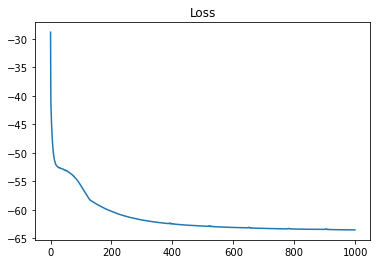

In [7]:
plt.plot(torch.tensor(losses).detach().numpy())
plt.title("Loss")

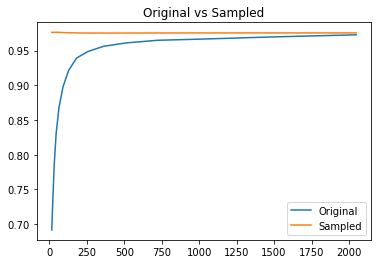

In [11]:
# Now lets compare
plt.plot(tts,torch.tensor(win.data[0,0,:,-1],dtype=torch.float), label="Original")

# We sample 1000 times and take the mean
means = params[0].repeat(tts.shape[0])
cov = cov_kernel(tts,tts[...,None],params[1:])

S = tdb.MultivariateNormal(means,cov).sample(sample_shape=torch.Size([1000])).mean(0)
plt.plot(tts,S, label="Sampled")

plt.title("Original vs Sampled")
plt.legend()


Text(0.5, 1.0, 'Sampled')

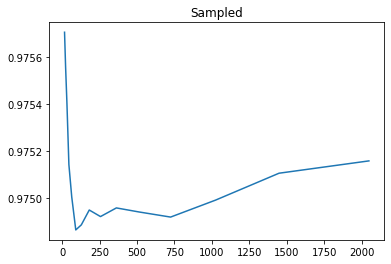

In [9]:
# We sample 1000 times and take the mean
means = params[0].repeat(ts.shape[0])
cov = cov_kernel(ts,ts[...,None],params[1:])

S = tdb.MultivariateNormal(means,cov).sample(sample_shape=torch.Size([1000])).mean(0)
plt.plot(ts,S)
plt.title("Sampled")

# Conclusion
Looks like these are the things that solved it:
- tricking torch into doing exponentials of negative numbers (by using torch.sign) as it can't do (-2)^0.5
- using a small sigma clamp (so sigma can't be lower than 0.001) to avoid non postive definite covariance matrix. This is because it kept trying to go to sigma = 0